In [9]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def f(x):
    return 3*x**2 - 4*x + 5

In [11]:
f(3.0)

20.0

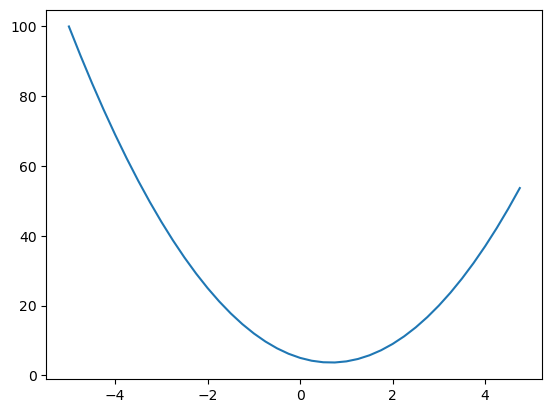

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [13]:
# class Value:

#     def __init__(self, data):
#         self.data = data
    
#     def __repr__(self):
#         return f"value(data={self.data})"
    
#     def __add__(self, other):
#         out = Value(self.data + other.data)
#         return out 
    
#     def __mul__(self, other):
#         out = Value(self.data * other.data)
#         return out


In [14]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a * b + c 

Value(data=4.0)

In [15]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '+')
        return out    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out

In [16]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = "e"
d = e + c; d.label = 'd' 
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [17]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [18]:
e = d+a
e._prev

{Value(data=2.0), Value(data=4.0)}

In [19]:
# Visualization #
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

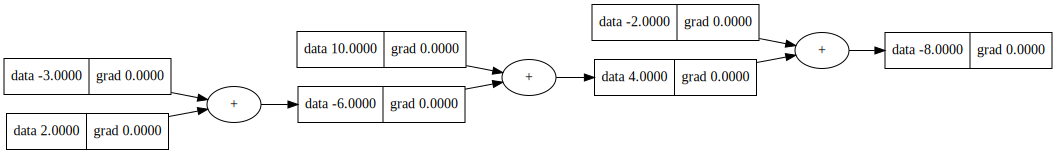

In [20]:
draw_dot(L)

In [21]:
# tiny helper function to double check derivatives
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = "e"
    d = e + c; d.label = 'd' 
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = "e"
    e.data += h
    d = e + c; d.label = 'd' 
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()

-2.000000000000668


## Backpropagationg through a Neuron ##

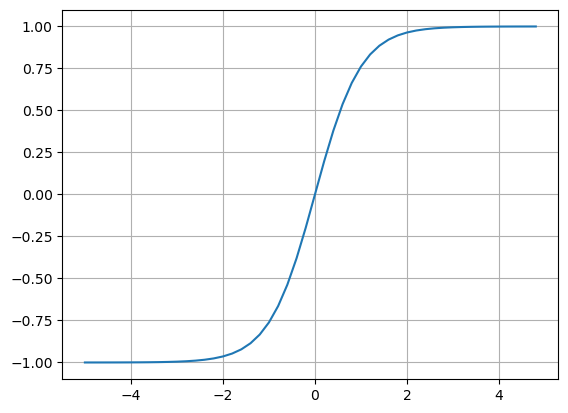

In [22]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); 
plt.grid()

In [23]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(0.0, label='w2')

# bias of the neuron
b = Value(8.0, label='b')

#x1w1 * x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

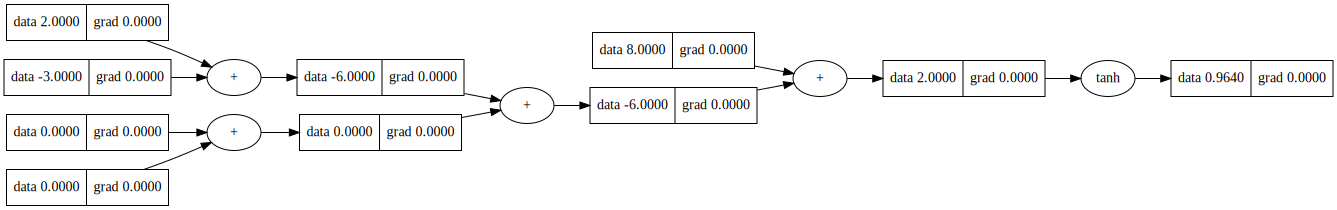

In [24]:
draw_dot(o)

we need to revisit the Value class to formalize backpropagation in it

In [53]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 

        return out 
    
    def __radd__(self, other):  # For handling float + Value
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out    
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): # - self
        return self * -1 

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out 

    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [28]:
o.grad = 1.0

In [29]:
o._backward()

AttributeError: 'Value' object has no attribute '_backward'

# Pytorch #

In [30]:
import torch

In [31]:
x1 = torch.Tensor([2.0]).double()           ; x1.requires_grad = True
x2= torch.Tensor([0.0]).double()            ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()          ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()           ; w2.requires_grad = True
b = torch.Tensor([6.88137358]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [32]:
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


just as we saw we can match the pytorch API on the autograd side, we are going to try to do that on the neural network module

In [62]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self): #collect the params all in one array
        return self.w + [self.b]

In [34]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9085608056681382)

next step we are going to define a layer of neurons

In [64]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self): #added later, convenience thing
       return [p for neuron in self.neurons for p in neuron.parameters()]

In [36]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9162204550968402),
 Value(data=0.5867704279494181),
 Value(data=-0.3460638527232299)]

now we define an entire multilayer perceptron 

In [68]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [69]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x) 

Value(data=-0.8158431827556127)

In [70]:
n.parameters()

[Value(data=-0.6435622259252414),
 Value(data=-0.22254636987589893),
 Value(data=-0.47090828455878553),
 Value(data=0.7459611891628033),
 Value(data=0.44928988540311177),
 Value(data=0.48445118205132065),
 Value(data=0.5399338566112895),
 Value(data=0.5724616620819729),
 Value(data=-0.6229149452642468),
 Value(data=0.7948573696563335),
 Value(data=-0.9492062857835291),
 Value(data=0.8182553928630034),
 Value(data=-0.12284188771022109),
 Value(data=-0.789213384040218),
 Value(data=0.5048690139792131),
 Value(data=0.7666035084026803),
 Value(data=-0.5300168203765283),
 Value(data=0.45594459946137045),
 Value(data=0.9715914561746519),
 Value(data=-0.18292092532820914),
 Value(data=-0.490336112042286),
 Value(data=0.8096316382636062),
 Value(data=-0.62352729448853),
 Value(data=-0.35841497406498735),
 Value(data=-0.2815248348514712),
 Value(data=0.6872312899022561),
 Value(data=-0.40155652291300514),
 Value(data=0.26194046588405717),
 Value(data=0.07974611563698697),
 Value(data=0.09359943

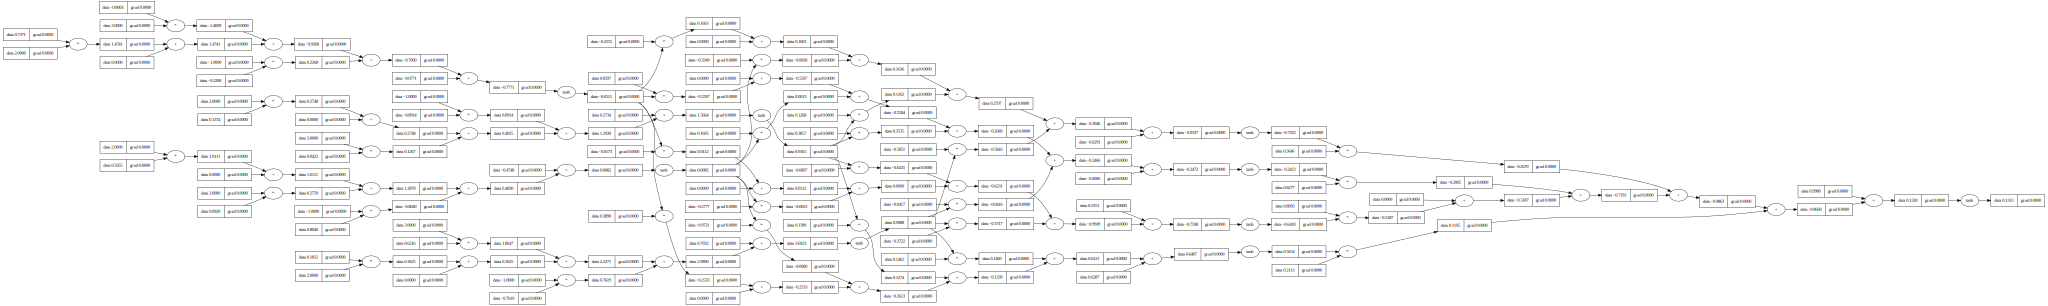

In [39]:
draw_dot(n(x))

with micrograd we will be able to backpropagate all the way through the massive graph above, specifically into the weights of all those neurons

Let's start with one simple example of a neural net on a dummy dataset. below there is such an example, where we have 4 possible inputs into the neural nets, and 4 possible outputs. this is a basic binary classifier

In [71]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [72]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8158431827556127),
 Value(data=0.36766462578994086),
 Value(data=-0.415570932839771),
 Value(data=-0.7735458724117326)]

we see how we want to nudge the outputs based on what we want to obtain (ys). How do we do that? the trick is to calculate a single number that measure the total performance of the net, the Loss function. we want to minimise the loss. We define the loss below as mean squared error

In [73]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=8.654815289087642)

In [54]:
p = Value(3.4)
print(p**2)

Value(data=11.559999999999999)


In [74]:
loss.backward()

In [75]:
n.layers[0].neurons[0].w[0].grad

0.8530957217484243

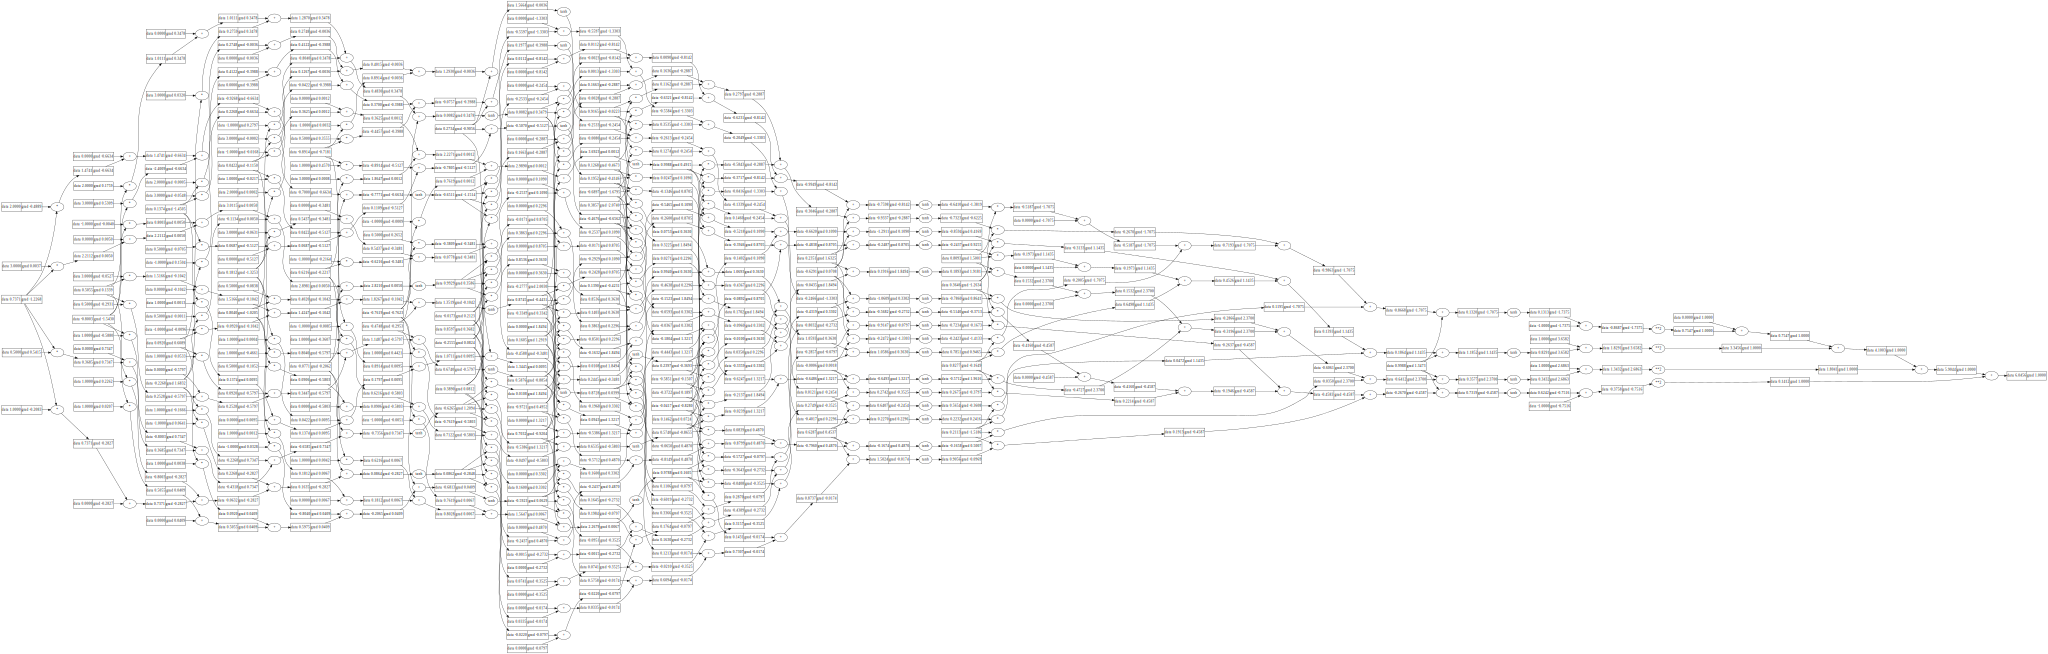

In [61]:
draw_dot(loss)

we happen to have gradients for the input layer as well but those values are not tweakable, it's a given, it is the input basically

now we are going to update the weights in the oppposite direction of the Loss, to decrease it (gradient descent). Basically backpropagation is the method for computing the gradients, while gradient descent is the method using these gradients to optimize the NN weights (learning)

In [76]:
for p in n.parameters():
    p.data += -0.01 * p.grad

Now we want to re-evaluate the loss as we expect that it went down a bit, since we nudged all the gradients towards the direction to minimise the loss

In [78]:
# recalculate the forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=8.173033505528752)

Now we just need to repeat this process. We need to recalculate the gradients again as we moved through the loss surface, therefore our gradients have changed. 

In [79]:
loss.backward()

In [80]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [82]:
# recalculate the forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.28995231065085)

we just keep on doing this until we minimise the loss. this is gradient descent basically. 

In [83]:
ypred 

[Value(data=-0.7766626309216776),
 Value(data=0.013219172171337902),
 Value(data=-0.5283479782308086),
 Value(data=-0.698338448614638)]

In [84]:
n.parameters()

[Value(data=-0.6674942201507933),
 Value(data=-0.22752001940679967),
 Value(data=-0.49180108804149075),
 Value(data=0.733043035098086),
 Value(data=0.4539209493503688),
 Value(data=0.47766418354875406),
 Value(data=0.5479523543386718),
 Value(data=0.5715858839397466),
 Value(data=-0.6142930213832667),
 Value(data=0.8063174122027467),
 Value(data=-0.9335289582002617),
 Value(data=0.8318185581290162),
 Value(data=-0.13743892285591092),
 Value(data=-0.7812707429453453),
 Value(data=0.4720156010873079),
 Value(data=0.759400481582345),
 Value(data=-0.568774612956748),
 Value(data=0.4855647884041897),
 Value(data=0.9159812870983118),
 Value(data=-0.12458119316275151),
 Value(data=-0.4631984669014473),
 Value(data=0.8062762681574078),
 Value(data=-0.6222308313158461),
 Value(data=-0.3661385570884528),
 Value(data=-0.27398265977605474),
 Value(data=0.6881447455609961),
 Value(data=-0.36991233897197145),
 Value(data=0.2548168429555355),
 Value(data=0.15744176243999813),
 Value(data=0.0190401280

Let's make a better loop about it

In [107]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x) 

Value(data=0.6097451547230028)

In [108]:
# re initialise the network

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [109]:
# train the network

for k in range(10): #training for just 20 steps

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass (calculate the gradients)
    for p in n.parameters():
        p.grad = 0.0 # we need to flush the gradients before, we do not want to add up to them
    loss.backward()

    #update the weights
    for p in n.parameters():
        p.data += -0.01 * p.grad #can adjust the learning rate

    print(k, loss.data)

0 3.370383855049603
1 3.256476797046707
2 3.1261974219950504
3 2.975235026346353
4 2.801122561185193
5 2.6045112482274053
6 2.3901596871782056
7 2.1665358904844307
8 1.9437331156855877
9 1.7308416749976152


In [100]:
ypred

[Value(data=0.9999999980413156),
 Value(data=-0.9999999999999746),
 Value(data=-0.9999999999999746),
 Value(data=0.999999998040918)]

## sumary of what we learn ##

what are NN 
NN are these mathematical expressions that take input as the data and weights 